In [1]:
import pandas as pd
import numpy as np
import pickle
import gc
import hyperdash as hd

%load_ext autoreload

In [ ]:
#'store_nbr', 'n_city', 'n_state', 'n_type', 'cluster', 'item_nbr', 'n_family', 'class', 'perishable'

In [2]:
unit_mean, unit_std = pd.read_csv('data/mean_std.csv', index_col=0).T[0]

In [5]:
df_items['class'].max()

254

In [14]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
item_nbr      4100 non-null int32
n_family      4100 non-null uint32
class         4100 non-null int32
perishable    4100 non-null int8
dtypes: int32(2), int8(1), uint32(1)
memory usage: 52.1 KB


In [4]:
df_stores = pd.read_csv(
    'data/num_stores.csv.gz',
     dtype={
         'store_nbr': np.uint8,
         'n_city': np.uint32,
         'n_state': np.uint32,
         'n_type': np.uint32,
         'cluster': np.uint32
     }

)
df_items = pd.read_csv(
    'data/num_items.csv.gz',
    dtype={
        'item_nbr': np.int32,
        'n_family': np.int32,
        'class': np.int32,
        'perishable': np.int8,
    }
)
for stores_col in ['n_city', 'n_state', 'n_type', 'cluster']:
    df_stores[stores_col] = df_stores[stores_col] - df_stores[stores_col].min()
    
for items_col in ['n_family', 'class', 'perishable']:
    df_items[items_col] = df_items[items_col] - df_items[items_col].min()

In [6]:
%%time
df = pd.read_csv(
    'data/ts.csv.gz',
    parse_dates=[0],
    #nrows=1000000,
    dtype={
        'item_nbr': np.int32,
        'store_nbr': np.int8,
        'unit_sales': np.float32,
        'onpromotion': np.int8,
        'holiday': np.int8,
        'weekend': np.int8,
        'waged_day': np.int8,
        'dow_0': np.int8,
        'dow_1': np.int8,
        'dow_2': np.int8,
        'dow_3': np.int8,
        'dow_4': np.int8,
        'dow_5': np.int8,
        'dow_6': np.int8,
    }
)
df.head()

CPU times: user 5min 34s, sys: 18.3 s, total: 5min 52s
Wall time: 5min 10s


In [7]:
%%time
ts_columns = df.columns[3:]
      
attr_cols = [
    'store_nbr', 'n_city', 'n_state', 'n_type', 'cluster',
    'item_nbr', 'n_family', 'class',
    #'perishable'
]

df_pivot = df.pivot_table(
    index=['store_nbr', 'item_nbr'],
    columns=['date'],
    values=ts_columns
).reset_index()

df_pivot = df_pivot.merge(df_items, on='item_nbr')
df_pivot['store_nbr'] = df_pivot[('store_nbr', '')]
df_pivot = df_pivot.merge(df_stores, on='store_nbr')

/home/dmitry/miniconda3/envs/tf_intel/lib/python3.5/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


CPU times: user 12min 49s, sys: 2min 43s, total: 15min 32s
Wall time: 12min 14s


In [8]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210654 entries, 0 to 210653
Columns: 9887 entries, item_nbr to cluster
dtypes: float64(823), int32(1), int64(4), int8(9054), uint32(5)
memory usage: 3.1 GB


In [112]:
def get_date_cols(date, history=20, predict_days=16, ts_columns=ts_columns, skip=0):
                  #date, days=1, attr_cols=attr_columns_wo_means, ts_cols=ts_columns, attr=True):
    
    if type(date) != pd.Timestamp:
        date = pd.to_datetime(date)
        
    X_start_date = date - pd.Timedelta('{} days'.format(history-1))
    #X_end_date = date
    y_start_date = date + pd.Timedelta('{} days'.format(skip+1))
    #y_end_date = date + pd.Timedelta('{} days'.format(predict_days))

    X_cols, y_cols, y_day_attr_cols = [], [], []
    
    for d in pd.date_range(X_start_date, periods=history, freq='D'):
        for elem in ts_columns:
            X_cols.append((elem, d))
            
    for d in pd.date_range(y_start_date, periods=predict_days, freq='D'):
        y_cols.append(('unit_sales_scaled', d))
        for elem in ts_columns[1:]:
            y_day_attr_cols.append((elem, d))
            
    return X_cols, y_cols, y_day_attr_cols



X_cols, y_cols, y_day_attr_cols = get_date_cols('2017-07-30', predict_days=16)
    
df_pivot.head().loc[:, y_day_attr_cols]

,"(onpromotion, 2017-07-31 00:00:00)","(holiday, 2017-07-31 00:00:00)","(weekend, 2017-07-31 00:00:00)","(waged_day, 2017-07-31 00:00:00)","(dow_0, 2017-07-31 00:00:00)","(dow_1, 2017-07-31 00:00:00)","(dow_2, 2017-07-31 00:00:00)","(dow_3, 2017-07-31 00:00:00)","(dow_4, 2017-07-31 00:00:00)","(dow_5, 2017-07-31 00:00:00)",...,"(holiday, 2017-08-15 00:00:00)","(weekend, 2017-08-15 00:00:00)","(waged_day, 2017-08-15 00:00:00)","(dow_0, 2017-08-15 00:00:00)","(dow_1, 2017-08-15 00:00:00)","(dow_2, 2017-08-15 00:00:00)","(dow_3, 2017-08-15 00:00:00)","(dow_4, 2017-08-15 00:00:00)","(dow_5, 2017-08-15 00:00:00)","(dow_6, 2017-08-15 00:00:00)"
0,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [10]:
def get_random_train_test(df_pivot,
        date, window=21, freq=7, size=2000, history=1, predict_days=16, epochs=2, 
        shuffle_dates=True, shuffle_indexes=True, attr_cols=attr_cols, ts_columns=ts_columns, skip=0):
    
    
    window = freq * (window//freq)
    num_items = df_pivot.shape[0]
    
    date = pd.to_datetime(date)
    start_window =  date - pd.Timedelta('{} days'.format(window))
    end_date = date
    
    dates = pd.date_range(start=start_window, end=end_date)
    dates = dates[::freq]
    
    print(dates)
    
    patches = []
    #end_X_date = end_date - pd.Timedelta('{} days'.format(label_dates))
    if shuffle_dates and shuffle_indexes:
        permutated_dates = np.random.permutation(dates)
        permutated_indx = np.random.permutation(num_items)   
        for epoch in range(epochs):
            for i in range(num_items//size+1):
                s = size * i
                e = size * (i+1)
                indexes = permutated_indx[s:e]

                for date in permutated_dates:
                    patches.append([indexes, date])

        patches = np.random.permutation(patches)
        
    elif not shuffle_dates and shuffle_indexes:
        permutated_indx = np.random.permutation(num_items)
        for date in dates:
            for epoch in range(epochs):
                for i in range(num_items//size+1):
                    s = size * i
                    e = size * (i+1)
                    indexes = permutated_indx[s:e]
                    patches.append([indexes, date])

    for indexes, date in patches:
        df_pivot_slice = df_pivot.iloc[indexes]
        X_cols, y_cols, y_day_attr_cols = get_date_cols(
            date, history=history, predict_days=predict_days, ts_columns=ts_columns, skip=skip
        )

        X = np.array(
            df_pivot_slice.loc[:, X_cols]
        ).reshape([-1, history, len(ts_columns)])

        y_day_attr = np.array(
            df_pivot_slice.loc[:, y_day_attr_cols]
        ).reshape([-1, predict_days, len(ts_columns)-1])
        
        y = np.array(df_pivot_slice.loc[:, y_cols])
        features = [X, y_day_attr, y]
        for feature in attr_cols:
            features.append(
                np.array(df_pivot_slice.loc[:, feature])
            )
        for i in range(len(indexes)):
            yield tuple([elem[i] for elem in features])

tmp = get_random_train_test(df_pivot, '2017-07-15', window=20, history=90, predict_days=5)
tmp1 = next(tmp)
print(tmp1[0].shape, tmp1[1].shape, tmp1[2].shape, tmp1[3].shape)

DatetimeIndex(['2017-07-01', '2017-07-08', '2017-07-15'], dtype='datetime64[ns]', freq='7D')
(90, 12) (5, 11) (5,) ()


In [147]:
for i in range(2000):
    next(tmp)

In [148]:
next(tmp)

(array([[-0.71689729,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.71689729,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.71689729,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [-0.71689729,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.71689729,  0.        ,  0.        , ...,  1.        ,
          0.        ,  0.        ],
        [-0.71689729,  0.        ,  0.        , ...,  0.        ,
          1.        ,  0.        ]]), array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8), array([-0.71689729, -0.71689729, -0.71689729, -0.71689729, -0.71689729]), 36, 11, 6, 4, 9, 1960806, 30, 106)

In [11]:
def get_validation(df_pivot,
        date, history=1, predict_days=16, attr_cols=attr_cols, ts_columns=ts_columns, skip=0):
    
    X_cols, y_cols, y_day_attr_cols = get_date_cols(
        date, history=history, predict_days=predict_days, ts_columns=ts_columns, skip=skip
    )

    X = np.array(
        df_pivot.loc[:, X_cols]
    ).reshape([-1, history, len(ts_columns)])
    
    y_day_attr = np.array(
        df_pivot.loc[:, y_day_attr_cols]
    ).reshape([-1, predict_days, len(ts_columns)-1])

    y = np.array(df_pivot.loc[:, y_cols])
    features = [X, y_day_attr, y]
    for feature in attr_cols:
        features.append(
            np.array(df_pivot.loc[:, feature])
        )

    return features

tmp = get_validation(df_pivot, '2017-07-15', history=90, predict_days=5)
print(tmp[0].shape, tmp[1].shape, tmp[2].shape, tmp[3].shape)

(210654, 90, 12) (210654, 5, 11) (210654, 5) (210654,)


In [ ]:
%autoreload 2

history = 400
time_to_predict = 16
freq=1

last_day_train = '2017-07-30'
window=300
epochs = 100
validation_day = pd.to_datetime(last_day_train) #+ pd.Timedelta('{} days'.format(time_to_predict))
batch_size = 1000
sum_W = 3574368.0/16
skip=0

print(validation_day)

batch_gen = get_random_train_test(
    df_pivot,
    last_day_train,
    window=window,
    history=history,
    size=batch_size,
    predict_days=time_to_predict,
    epochs=epochs,
    skip=skip,
    freq=freq
)

val_set = get_validation(df_pivot, validation_day, history=history,
                        predict_days=time_to_predict, skip=skip)

from model import RNNModel

m = RNNModel(
    history=history,
    n_days_predict=time_to_predict,
    clip_gradients=1.,
    starter_learning_rate=0.0001,
    #starter_learning_rate=0.0005,
    n_layers_rnn=1,
    rnn_size_encoder=400,
    rnn_size_decoder=400,
    #output_droupouts_kp=[.9, .9, .9, .95, 1.]
)
print(1)
m.build_graph(batch_gen)


try:
    hd_exp.end()
except NameError:
    pass

hd_exp = hd.Experiment('RNN fav 3')

m.train(val_set, coef=unit_std, sum_W=sum_W,
        report_every=100, validate_every=0,
        hd_exp=hd_exp, )

2017-07-30 00:00:00
1
DatetimeIndex(['2016-10-03', '2016-10-04', '2016-10-05', '2016-10-06',
               '2016-10-07', '2016-10-08', '2016-10-09', '2016-10-10',
               '2016-10-11', '2016-10-12',
               ...
               '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
               '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28',
               '2017-07-29', '2017-07-30'],
              dtype='datetime64[ns]', length=301, freq='D')
g_step: 100 loss std/mean: 0.18680866062641144 0.42838025093078613
| Loss std:   0.186809 |
| Loss mean:   0.428380 |
g_step: 200 loss std/mean: 0.041691552847623825 0.3153567314147949
| Loss std:   0.041692 |
| Loss mean:   0.315357 |
g_step: 300 loss std/mean: 0.05267135426402092 0.30759337544441223
| Loss std:   0.052671 |
| Loss mean:   0.307593 |
g_step: 400 loss std/mean: 0.043438930064439774 0.29899081587791443
| Loss std:   0.043439 |
| Loss mean:   0.298991 |
g_step: 500 loss std/mean: 0.05342321842908859 0.305109

| Loss mean:   0.266432 |
g_step: 6700 loss std/mean: 0.027530472725629807 0.26132261753082275
| Loss std:   0.027530 |
| Loss mean:   0.261323 |
g_step: 6800 loss std/mean: 0.02660738304257393 0.26949432492256165
| Loss std:   0.026607 |
| Loss mean:   0.269494 |
g_step: 6900 loss std/mean: 0.027821796014904976 0.2603154182434082
| Loss std:   0.027822 |
| Loss mean:   0.260315 |
g_step: 7000 loss std/mean: 0.027715658769011497 0.2733796238899231
| Loss std:   0.027716 |
| Loss mean:   0.273380 |
g_step: 7100 loss std/mean: 0.02370106801390648 0.26285943388938904
| Loss std:   0.023701 |
| Loss mean:   0.262859 |
g_step: 7200 loss std/mean: 0.03714468702673912 0.27416127920150757
| Loss std:   0.037145 |
| Loss mean:   0.274161 |
g_step: 7300 loss std/mean: 0.03158896043896675 0.2616395950317383
| Loss std:   0.031589 |
| Loss mean:   0.261640 |
g_step: 7400 loss std/mean: 0.026022374629974365 0.25453174114227295
| Loss std:   0.026022 |
| Loss mean:   0.254532 |
g_step: 7500 loss std

| Loss mean:   0.256965 |
g_step: 13600 loss std/mean: 0.02232358604669571 0.25543680787086487
| Loss std:   0.022324 |
| Loss mean:   0.255437 |
g_step: 13700 loss std/mean: 0.023311911150813103 0.257748544216156
| Loss std:   0.023312 |
| Loss mean:   0.257749 |
g_step: 13800 loss std/mean: 0.022356431931257248 0.2589523196220398
| Loss std:   0.022356 |
| Loss mean:   0.258952 |
g_step: 13900 loss std/mean: 0.0242281723767519 0.2606947720050812
| Loss std:   0.024228 |
| Loss mean:   0.260695 |
g_step: 14000 loss std/mean: 0.02422790788114071 0.25539523363113403
| Loss std:   0.024228 |
| Loss mean:   0.255395 |
g_step: 14100 loss std/mean: 0.020991899073123932 0.25351396203041077
| Loss std:   0.020992 |
| Loss mean:   0.253514 |
g_step: 14200 loss std/mean: 0.026657741516828537 0.25687530636787415
| Loss std:   0.026658 |
| Loss mean:   0.256875 |
g_step: 14300 loss std/mean: 0.022753367200493813 0.253953754901886
| Loss std:   0.022753 |
| Loss mean:   0.253954 |
g_step: 14400 lo

| Loss mean:   0.251263 |
g_step: 20500 loss std/mean: 0.023093726485967636 0.2480752021074295
| Loss std:   0.023094 |
| Loss mean:   0.248075 |
g_step: 20600 loss std/mean: 0.022907646372914314 0.25124019384384155
| Loss std:   0.022908 |
| Loss mean:   0.251240 |
g_step: 20700 loss std/mean: 0.022188808768987656 0.24917249381542206
| Loss std:   0.022189 |
| Loss mean:   0.249172 |
g_step: 20800 loss std/mean: 0.017988527193665504 0.2486860454082489
| Loss std:   0.017989 |
| Loss mean:   0.248686 |
g_step: 20900 loss std/mean: 0.01767357625067234 0.2527101933956146
| Loss std:   0.017674 |
| Loss mean:   0.252710 |
g_step: 21000 loss std/mean: 0.02018549107015133 0.2507101893424988
| Loss std:   0.020185 |
| Loss mean:   0.250710 |
g_step: 21100 loss std/mean: 0.020849797874689102 0.24935390055179596
| Loss std:   0.020850 |
| Loss mean:   0.249354 |
g_step: 21200 loss std/mean: 0.02446189522743225 0.25001242756843567
| Loss std:   0.024462 |
| Loss mean:   0.250012 |
g_step: 21300

g_step: 27300 loss std/mean: 0.021013258025050163 0.24996507167816162
| Loss std:   0.021013 |
| Loss mean:   0.249965 |
g_step: 27400 loss std/mean: 0.02095433697104454 0.24359552562236786
| Loss std:   0.020954 |
| Loss mean:   0.243596 |
g_step: 27500 loss std/mean: 0.02079959586262703 0.25124824047088623
| Loss std:   0.020800 |
| Loss mean:   0.251248 |
g_step: 27600 loss std/mean: 0.020838940516114235 0.2471330612897873
| Loss std:   0.020839 |
| Loss mean:   0.247133 |
g_step: 27700 loss std/mean: 0.020577194169163704 0.24371787905693054
| Loss std:   0.020577 |
| Loss mean:   0.243718 |
g_step: 27800 loss std/mean: 0.023074695840477943 0.24859628081321716
| Loss std:   0.023075 |
| Loss mean:   0.248596 |
g_step: 27900 loss std/mean: 0.020735761150717735 0.24590785801410675
| Loss std:   0.020736 |
| Loss mean:   0.245908 |
g_step: 28000 loss std/mean: 0.020948484539985657 0.2505885064601898
| Loss std:   0.020948 |
| Loss mean:   0.250589 |
g_step: 28100 loss std/mean: 0.02058

| Loss mean:   0.243824 |
g_step: 34200 loss std/mean: 0.020888950675725937 0.2532919943332672
| Loss std:   0.020889 |
| Loss mean:   0.253292 |
g_step: 34300 loss std/mean: 0.0200667642056942 0.2490285485982895
| Loss std:   0.020067 |
| Loss mean:   0.249029 |
g_step: 34400 loss std/mean: 0.01934339664876461 0.24307331442832947
| Loss std:   0.019343 |
| Loss mean:   0.243073 |
g_step: 34500 loss std/mean: 0.02110474556684494 0.24453094601631165
| Loss std:   0.021105 |
| Loss mean:   0.244531 |
g_step: 34600 loss std/mean: 0.01921342872083187 0.243904247879982
| Loss std:   0.019213 |
| Loss mean:   0.243904 |
g_step: 34700 loss std/mean: 0.02123941108584404 0.24790643155574799
| Loss std:   0.021239 |
| Loss mean:   0.247906 |
g_step: 34800 loss std/mean: 0.023813076317310333 0.2426929920911789
| Loss std:   0.023813 |
| Loss mean:   0.242693 |
g_step: 34900 loss std/mean: 0.020169490948319435 0.24918556213378906
| Loss std:   0.020169 |
| Loss mean:   0.249186 |
g_step: 35000 los

g_step: 41000 loss std/mean: 0.022882582619786263 0.24029295146465302
| Loss std:   0.022883 |
| Loss mean:   0.240293 |
g_step: 41100 loss std/mean: 0.021094871684908867 0.24252286553382874
| Loss std:   0.021095 |
| Loss mean:   0.242523 |
g_step: 41200 loss std/mean: 0.020838120952248573 0.2448587417602539
| Loss std:   0.020838 |
| Loss mean:   0.244859 |
g_step: 41300 loss std/mean: 0.02060607820749283 0.24449287354946136
| Loss std:   0.020606 |
| Loss mean:   0.244493 |
g_step: 41400 loss std/mean: 0.020432842895388603 0.24242812395095825
| Loss std:   0.020433 |
| Loss mean:   0.242428 |
g_step: 41500 loss std/mean: 0.022617321461439133 0.24376451969146729
| Loss std:   0.022617 |
| Loss mean:   0.243765 |
g_step: 41600 loss std/mean: 0.017855998128652573 0.24455831944942474
| Loss std:   0.017856 |
| Loss mean:   0.244558 |
g_step: 41700 loss std/mean: 0.0207743551582098 0.24202550947666168
| Loss std:   0.020774 |
| Loss mean:   0.242026 |
g_step: 41800 loss std/mean: 0.01959

| Loss mean:   0.243982 |
g_step: 47900 loss std/mean: 0.021398989483714104 0.23786741495132446
| Loss std:   0.021399 |
| Loss mean:   0.237867 |
g_step: 48000 loss std/mean: 0.019922861829400063 0.24559789896011353
| Loss std:   0.019923 |
| Loss mean:   0.245598 |
g_step: 48100 loss std/mean: 0.01956835575401783 0.24102722108364105
| Loss std:   0.019568 |
| Loss mean:   0.241027 |
g_step: 48200 loss std/mean: 0.022305158898234367 0.23841926455497742
| Loss std:   0.022305 |
| Loss mean:   0.238419 |
g_step: 48300 loss std/mean: 0.02101142331957817 0.245802104473114
| Loss std:   0.021011 |
| Loss mean:   0.245802 |
g_step: 48400 loss std/mean: 0.020018091425299644 0.23787905275821686
| Loss std:   0.020018 |
| Loss mean:   0.237879 |
g_step: 48500 loss std/mean: 0.01905027963221073 0.23830991983413696
| Loss std:   0.019050 |
| Loss mean:   0.238310 |
g_step: 48600 loss std/mean: 0.017857655882835388 0.24392284452915192
| Loss std:   0.017858 |
| Loss mean:   0.243923 |
g_step: 487

g_step: 54700 loss std/mean: 0.018409639596939087 0.24668273329734802
| Loss std:   0.018410 |
| Loss mean:   0.246683 |
g_step: 54800 loss std/mean: 0.02304353006184101 0.23876237869262695
| Loss std:   0.023044 |
| Loss mean:   0.238762 |
g_step: 54900 loss std/mean: 0.01710580475628376 0.23803383111953735
| Loss std:   0.017106 |
| Loss mean:   0.238034 |
g_step: 55000 loss std/mean: 0.018021371215581894 0.24125432968139648
| Loss std:   0.018021 |
| Loss mean:   0.241254 |
g_step: 55100 loss std/mean: 0.015948468819260597 0.24270056188106537
| Loss std:   0.015948 |
| Loss mean:   0.242701 |
g_step: 55200 loss std/mean: 0.019661474972963333 0.24089232087135315
| Loss std:   0.019661 |
| Loss mean:   0.240892 |
g_step: 55300 loss std/mean: 0.016232609748840332 0.24225814640522003
| Loss std:   0.016233 |
| Loss mean:   0.242258 |
g_step: 55400 loss std/mean: 0.017283810302615166 0.24294671416282654
| Loss std:   0.017284 |
| Loss mean:   0.242947 |
g_step: 55500 loss std/mean: 0.018

| Loss mean:   0.241394 |
g_step: 61600 loss std/mean: 0.019095346331596375 0.23566395044326782
| Loss std:   0.019095 |
| Loss mean:   0.235664 |
g_step: 61700 loss std/mean: 0.022170254960656166 0.23883208632469177
| Loss std:   0.022170 |
| Loss mean:   0.238832 |
g_step: 61800 loss std/mean: 0.017777008935809135 0.24206170439720154
| Loss std:   0.017777 |
| Loss mean:   0.242062 |
g_step: 61900 loss std/mean: 0.01921192929148674 0.237731471657753
| Loss std:   0.019212 |
| Loss mean:   0.237731 |
g_step: 62000 loss std/mean: 0.019168753176927567 0.24293066561222076
| Loss std:   0.019169 |
| Loss mean:   0.242931 |
g_step: 62100 loss std/mean: 0.021955296397209167 0.2363656610250473
| Loss std:   0.021955 |
| Loss mean:   0.236366 |
g_step: 62200 loss std/mean: 0.021849840879440308 0.24035340547561646
| Loss std:   0.021850 |
| Loss mean:   0.240353 |
g_step: 62300 loss std/mean: 0.018431531265378 0.2404937744140625
| Loss std:   0.018432 |
| Loss mean:   0.240494 |
g_step: 62400 

g_step: 68400 loss std/mean: 0.019524183124303818 0.23956885933876038
| Loss std:   0.019524 |
| Loss mean:   0.239569 |
g_step: 68500 loss std/mean: 0.017589813098311424 0.24793244898319244
| Loss std:   0.017590 |
| Loss mean:   0.247932 |
g_step: 68600 loss std/mean: 0.01762019842863083 0.24055646359920502
| Loss std:   0.017620 |
| Loss mean:   0.240556 |
g_step: 68700 loss std/mean: 0.019211385399103165 0.24149371683597565
| Loss std:   0.019211 |
| Loss mean:   0.241494 |
g_step: 68800 loss std/mean: 0.019352905452251434 0.2380613386631012
| Loss std:   0.019353 |
| Loss mean:   0.238061 |
g_step: 68900 loss std/mean: 0.017934778705239296 0.23968228697776794
| Loss std:   0.017935 |
| Loss mean:   0.239682 |
g_step: 69000 loss std/mean: 0.01675976812839508 0.2411826252937317
| Loss std:   0.016760 |
| Loss mean:   0.241183 |
g_step: 69100 loss std/mean: 0.019268905743956566 0.24044765532016754
| Loss std:   0.019269 |
| Loss mean:   0.240448 |
g_step: 69200 loss std/mean: 0.01977

| Loss mean:   0.240107 |
g_step: 75300 loss std/mean: 0.01665009744465351 0.23883360624313354
| Loss std:   0.016650 |
| Loss mean:   0.238834 |
g_step: 75400 loss std/mean: 0.018576916307210922 0.23830169439315796
| Loss std:   0.018577 |
| Loss mean:   0.238302 |
g_step: 75500 loss std/mean: 0.019859066233038902 0.23603178560733795
| Loss std:   0.019859 |
| Loss mean:   0.236032 |
g_step: 75600 loss std/mean: 0.018993064761161804 0.23388724029064178
| Loss std:   0.018993 |
| Loss mean:   0.233887 |
g_step: 75700 loss std/mean: 0.016337474808096886 0.23864158987998962
| Loss std:   0.016337 |
| Loss mean:   0.238642 |
g_step: 75800 loss std/mean: 0.01853819005191326 0.23682868480682373
| Loss std:   0.018538 |
| Loss mean:   0.236829 |
g_step: 75900 loss std/mean: 0.01997363567352295 0.23762378096580505
| Loss std:   0.019974 |
| Loss mean:   0.237624 |
g_step: 76000 loss std/mean: 0.017238015308976173 0.23699510097503662
| Loss std:   0.017238 |
| Loss mean:   0.236995 |
g_step: 7

In [31]:
sales = df[
    (df['item_nbr'] == 1503844) &
    (df['store_nbr'] == 44) 
    
]['unit_sales_scaled']

In [34]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

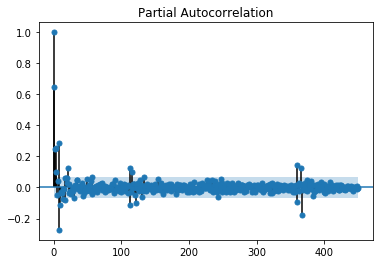

In [33]:
sm.graphics.tsa.plot_pacf(sales, lags=450)
plt.show()

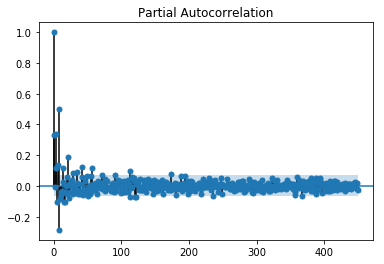

In [49]:
sales2, tmp = stats.boxcox((sales+unit_mean))
sm.graphics.tsa.plot_pacf(sales2, lags=450)
plt.show()